Получить значения AUC для различных моделей и их параметров

http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from pylab import rcParams
rcParams['figure.figsize'] = (14, 6)

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
data = pd.read_csv("adult_low.csv")

In [8]:
display(data.head())
display(data.info())
display(data.shape)
display(data.describe())
display(data.columns)
display(data.income.value_counts())

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         48842 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


None

(48842, 15)

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

<=50K    37155
>50K     11687
Name: income, dtype: int64

### Предобработка данных

In [9]:
data = data.fillna(np.nan)
data[data == '?'] = np.nan

In [23]:
# data.isnull().sum()

In [12]:
data = data.dropna()

In [14]:
data.isnull().sum().sum()

0

In [25]:
X, y = data.drop(['income', 'fnlwgt'], axis=1), data['income']

In [28]:
X["gender"] = X["gender"].map({"Male": 0, "Female":1})

In [36]:
# X.head()

In [34]:
le = LabelEncoder()

X = pd.get_dummies(X)
y = le.fit_transform(y)

### Разбиваем данные на X_train,...,y_test выборки и нормализуем данные

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [40]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((31655, 102), (13567, 102), (31655,), (13567,))

In [41]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# X_train = pd.DataFrame(sc.fit_transform(X_train), columns = X.columns)
# X_test = pd.DataFrame(sc.transform(X_test), columns = X.columns)

### LogisticRegression

In [51]:
lr = LogisticRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# lr.score(X_test, y_test)
print('Logistic Regression accuracy score: {0:0.4f}\n'. format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Logistic Regression accuracy score: 0.8410

              precision    recall  f1-score   support

           0       0.87      0.92      0.90     10142
           1       0.73      0.59      0.65      3425

    accuracy                           0.84     13567
   macro avg       0.80      0.76      0.78     13567
weighted avg       0.83      0.84      0.84     13567



In [60]:
penalty = ['l1', 'l2']
C = [0.001, 0.01, 0.1, 1.0, 10.0]

params = []
lines = []
scores = []

for p in penalty:
    for c in C:
        lr = LogisticRegression(penalty=p, C=c)
        lr.fit(X_train, y_train)
        
        probas = lr.predict_proba(X_test)[:,1] # это вероятности записываем в отдельную переменную (список)
        
        params.append((p,c))
        scores.append(roc_auc_score(y_test, probas))
        lines.append(roc_curve(y_test, probas))

In [61]:
for i in range(len(params)):
    print('{}_{}: {}'.format(params[i][0], params[i][1], scores[i]))

l1_0.001: 0.8750844144534472
l1_0.01: 0.8980390282801733
l1_0.1: 0.8993282109375337
l1_1.0: 0.899244163534741
l1_10.0: 0.8992338861164169
l2_0.001: 0.8932164720818393
l2_0.01: 0.8986071075400841
l2_0.1: 0.8992539515521925
l2_1.0: 0.8992360164496269
l2_10.0: 0.8992339436929901


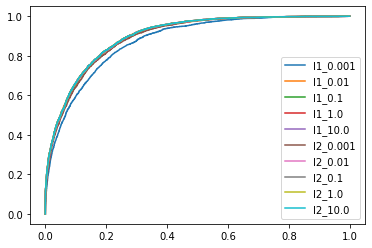

In [62]:
for i in range(len(params)):
    plt.plot(
        lines[i][0], 
        lines[i][1], 
        label='{}_{}'.format(
            params[i][0], 
            params[i][1]
        )
    )

plt.legend()
plt.show()

- Параметры для модели LogisticRegression 
    - penalty = l1
    - C = 0.1

### Построим несколько моделей и посмотрим AUC

In [88]:
label_est = [
    'RandomForestClassifier',
    'LogisticRegression',
    'XGBClassifier'
]

est_list = [
    RandomForestClassifier(),
    LogisticRegression(), 
    XGBClassifier()
]

est_greedsearchsv_param = [
    {
        'criterion':['gini', 'entropy'],
        'max_depth':[3, 5, 7]
    },
    {
        'penalty':['l1', 'l2'],
        'C':[0.01, 0.1, 1.0]
    },
    {
        'max_depth':[3, 4, 5]
    }
]

In [89]:
def models_auc(X_train_test, X_valid, y_train_test, y_valid):
    
    clf_list = []
    res_est = []
    predictions = []
    res_roc = []
    res_prec_recall = []


    for i in range(len(est_list)): 
        clf_list.append(
            GridSearchCV(
                est_list[i], 
                est_greedsearchsv_param[i], 
                cv=5
            )
        )
    
    for i in range(len(clf_list)):    
        clf_list[i].fit(X_train_test, y_train_test)
        res_est.append(
            clf_list[i].best_estimator_
        )

    for i in range(len(res_est)):
        predictions.append(
            res_est[i].predict_proba(X_valid)
        )

    for i in range(len(predictions)):   
        res_roc.append(
            list(roc_curve(y_valid, predictions[i][:, 1]))
        )
        
        res_prec_recall.append(
            list(precision_recall_curve(y_valid, predictions[i][:, 1]))
        )
    
    %config InlineBackend.figure_format = 'retina'
    plt.rcParams['figure.figsize'] = (14, 6)
    
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    
    for i in range(len(res_roc)):    
        ax1.plot(
            res_roc[i][0], 
            res_roc[i][1], 
            label = label_est[i]
        )
        ax2.plot(
            res_prec_recall[i][1], 
            res_prec_recall[i][0], 
            label = label_est[i]
        )
    
    ax1.set_title('ROC curve'), ax1.set_xlabel('False Positive Rate'), ax1.set_ylabel('True Positive Rate')
    ax2.set_title('Prec_recall curve'), ax2.set_xlabel('Recall'), ax2.set_ylabel('Precision')
    ax1.legend(loc = 0), ax2.legend(loc = 0)
    plt.show()

    for i in range(len(res_roc)):        
        print(
            '{0}\n{1}{2}\n{3}{4}\n\n'.format(
                label_est[i],
                'auc(roc) - ', auc(res_roc[i][0], res_roc[i][1]), 
                'auc(pr-re) - ', auc(res_prec_recall[i][1], res_prec_recall[i][0])
            )
        )
        
        
    return {
        'estimators': res_est, 
        'predictions': predictions, 
        'roc_curves':res_roc, 
        'precision_recall_curves':res_prec_recall
    }

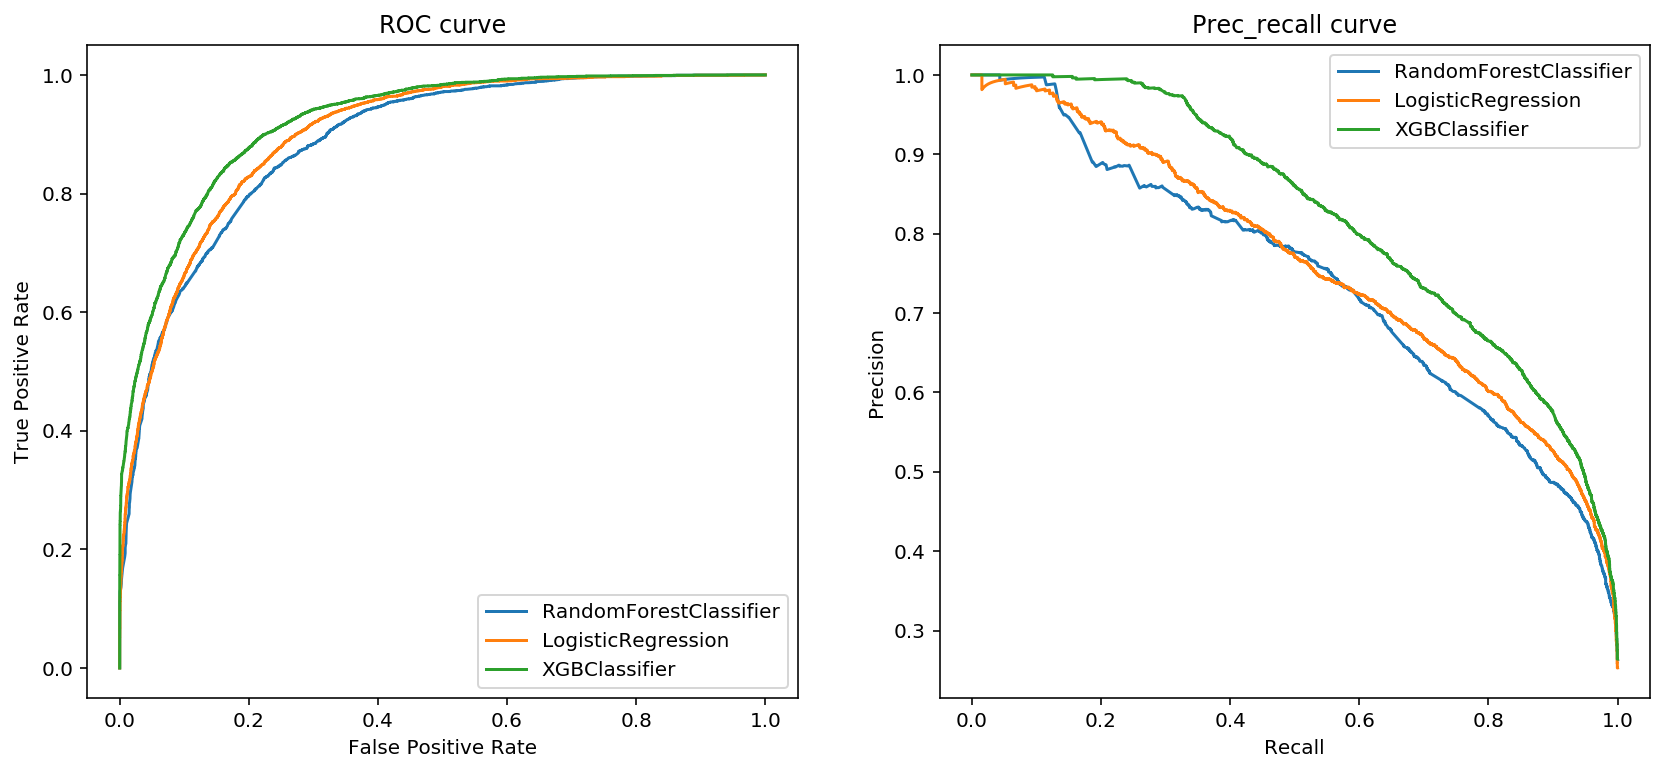

RandomForestClassifier
auc(roc) - 0.8872926199787831
auc(pr-re) - 0.7429012658271729


LogisticRegression
auc(roc) - 0.8993279230546675
auc(pr-re) - 0.7618530301267115


XGBClassifier
auc(roc) - 0.9211116165054761
auc(pr-re) - 0.8223115093231441




In [90]:
m_auc = models_auc(X_train, X_test, y_train, y_test)

In [ ]:
pass